Like all businesses, credit card companies depend on the presence and accessibility of customers. However, they face a significant challenge in customer attrition. Thus, credit card companies continually seek ways to comprehend the factors leading to customer attrition and ideally predict it before it occurs.

Numerous efforts have been directed towards this goal. While many have yielded commendable results, they often fail to address the crucial question: "What factors influence credit card churn?"

In this analysis, we will develop a predictive model to forecast churn and conduct a thorough examination of the factors influencing customer attrition and potentially how they do so. By doing this, we aim not only to anticipate customer behaviour but also to provide valuable insights that businesses can utilise to enhance customer retention and operational capabilities.

# Models to Use

In this analysis, we will employ two distinct methodologies: **Random Forest** and **Logistic Regression**.

**Random Forest (RF)** is utilised to construct a predictive model capable of determining whether a customer is likely to churn or not.

Furthermore, we conduct a feature importance analysis on the model to discern which features (factors) are deemed significant and which are not. While this analysis doesn't explicitly explain the relationship between these features and attrition, it provides insight into the crucial factors considered in constructing a credit card churn prediction model. Additionally, comparing these findings with the results from Logistic Regression allows us to gauge consistency and comprehensiveness across methodologies.

**Logistic Regression (LR)** models are often praised for their ability to explain, to a worthy degree, the relationship between factors and an event, and how a change in one can affect the other.

We will use LR to investigate what factors significantly contribute to the occurrence of attrition, and how a change in one of these features can influence attrition.

# Dataset to Use

The dataset used for this analysis was published by Anwar San and contains recorded observations of customers, including their attrition marker – existing customer or churned.

# Analysis and Implementations

First we install and load necessary libraries.

In [1]:
# Importing necessary libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
import statsmodels.api as sm
from boruta import BorutaPy
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load dataset

df = pd.read_csv("/kaggle/input/credit-card-bank-churn/credit_card_churn.csv")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

In [3]:
# Dropping last 2 columns and Client Number

'''
    Last two columns are to be dropped as advised by dataset publication.
'''

df = df.iloc[:, 1:-2]
df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [4]:
# View dataset info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

In [5]:
# Remove rows containing Unknowns

'''
    Some of the rows in the dataset contain "Unknown". Giving how large the dataset is,
    we will opt for dropping these rows for now instead of seeking to fill
    missing values.
    If good results can't be obtained with the new dataset, we will then seek to fill the
    missing values, perhaps it will improve results.
'''

dfNew = df[(df['Income_Category'] != 'Unknown') & (df['Education_Level'] != 'Unknown') & (df['Marital_Status'] != 'Unknown')].copy()

In [6]:
# Reset Index

dfNew = dfNew.reset_index(drop=True)
dfNew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7081 entries, 0 to 7080
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            7081 non-null   object 
 1   Customer_Age              7081 non-null   int64  
 2   Gender                    7081 non-null   object 
 3   Dependent_count           7081 non-null   int64  
 4   Education_Level           7081 non-null   object 
 5   Marital_Status            7081 non-null   object 
 6   Income_Category           7081 non-null   object 
 7   Card_Category             7081 non-null   object 
 8   Months_on_book            7081 non-null   int64  
 9   Total_Relationship_Count  7081 non-null   int64  
 10  Months_Inactive_12_mon    7081 non-null   int64  
 11  Contacts_Count_12_mon     7081 non-null   int64  
 12  Credit_Limit              7081 non-null   float64
 13  Total_Revolving_Bal       7081 non-null   int64  
 14  Avg_Open

In [7]:
# Turn categorical variables to categories

# Define mapping for categorical variables
categorical_mappings = {
    'Attrition_Flag': 'category',
    'Gender': 'category',
    'Education_Level': 'category',
    'Marital_Status': 'category',
    'Income_Category': 'category',
    'Card_Category': 'category'
}

# Convert specified columns to categorical
dfNew = dfNew.astype(categorical_mappings)
dfNew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7081 entries, 0 to 7080
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Attrition_Flag            7081 non-null   category
 1   Customer_Age              7081 non-null   int64   
 2   Gender                    7081 non-null   category
 3   Dependent_count           7081 non-null   int64   
 4   Education_Level           7081 non-null   category
 5   Marital_Status            7081 non-null   category
 6   Income_Category           7081 non-null   category
 7   Card_Category             7081 non-null   category
 8   Months_on_book            7081 non-null   int64   
 9   Total_Relationship_Count  7081 non-null   int64   
 10  Months_Inactive_12_mon    7081 non-null   int64   
 11  Contacts_Count_12_mon     7081 non-null   int64   
 12  Credit_Limit              7081 non-null   float64 
 13  Total_Revolving_Bal       7081 non-null   int64 

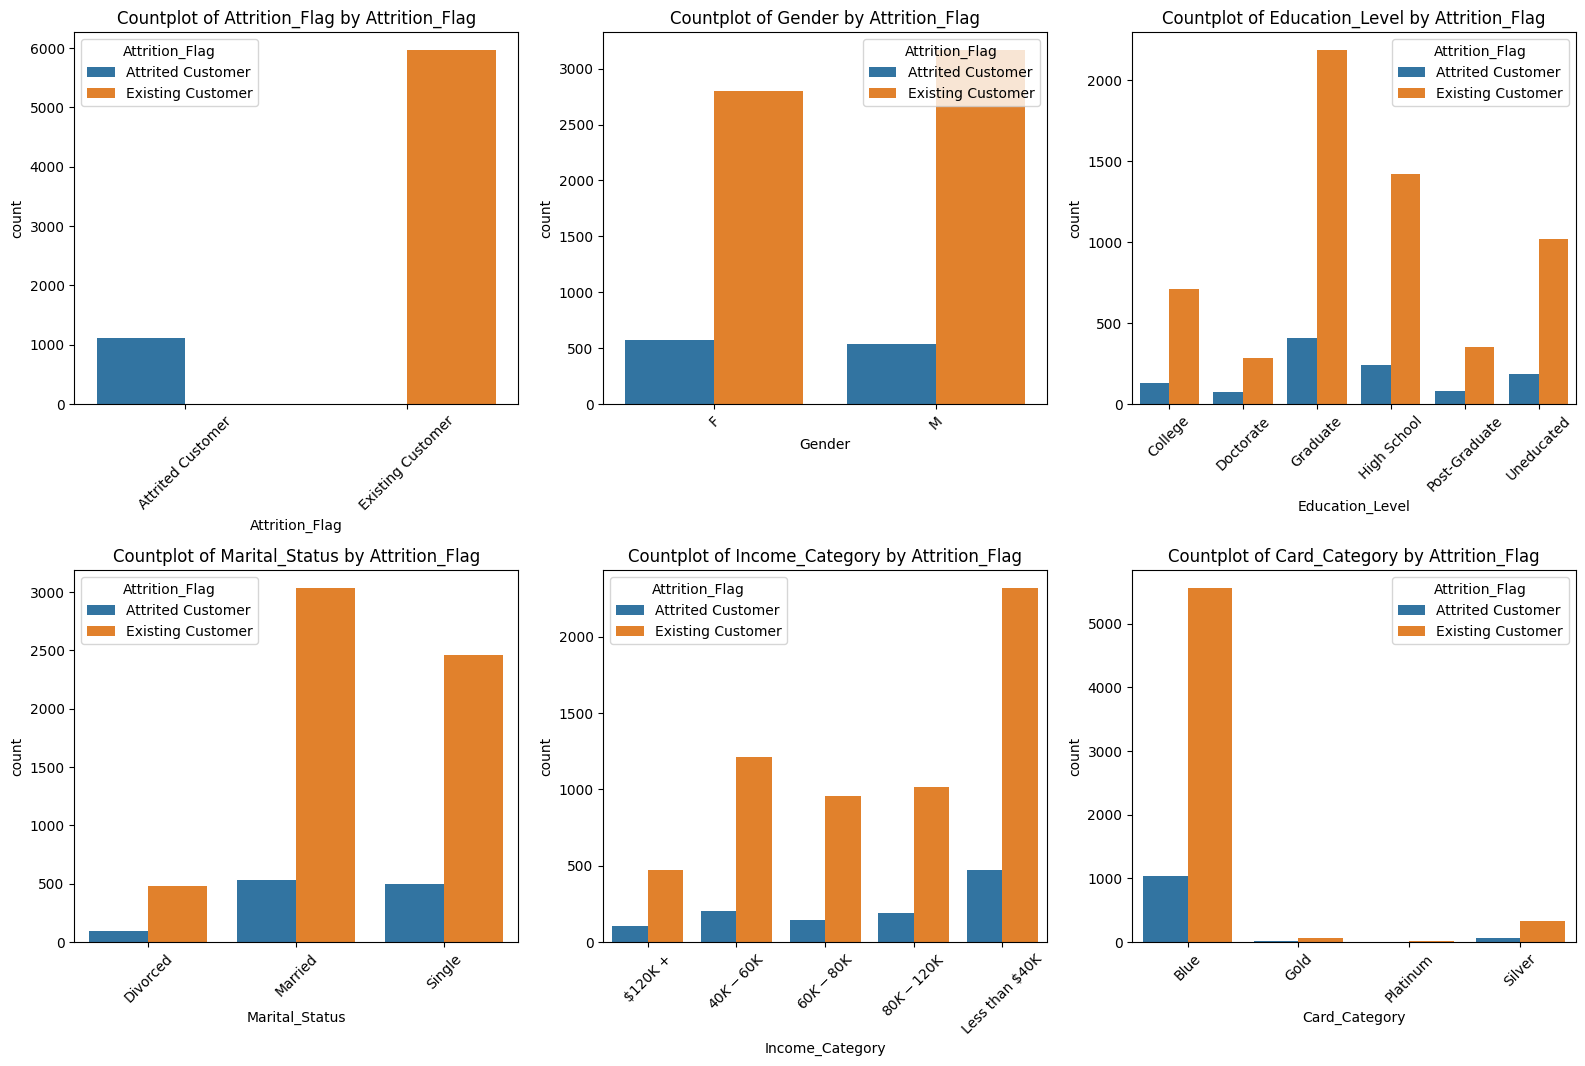

In [8]:
# Count/Bar plots of categories by attrition flags

categorical_columns = dfNew.select_dtypes(include='category').columns
plt.figure(figsize=(16, 15))
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(3, 3, i)
    sns.countplot(x=column, hue='Attrition_Flag', data=dfNew)
    plt.title(f'Countplot of {column} by Attrition_Flag')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

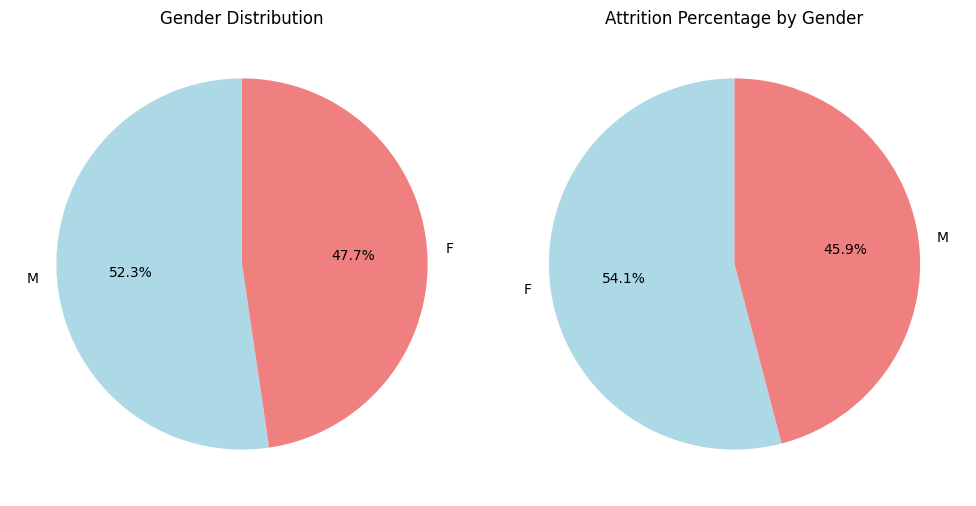

In [9]:
# Plot gender distribution of attrition

gender_counts = dfNew['Gender'].value_counts()
attrition_by_gender = dfNew.groupby('Gender')['Attrition_Flag'].value_counts(normalize=True).unstack()

# Plotting Pie Chart for Gender Distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
plt.title('Gender Distribution')

# Plotting Pie Chart for Attrition Percentage by Gender
plt.subplot(1, 2, 2)
plt.pie(attrition_by_gender['Attrited Customer'], labels=attrition_by_gender.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
plt.title('Attrition Percentage by Gender')

plt.tight_layout()
plt.show()


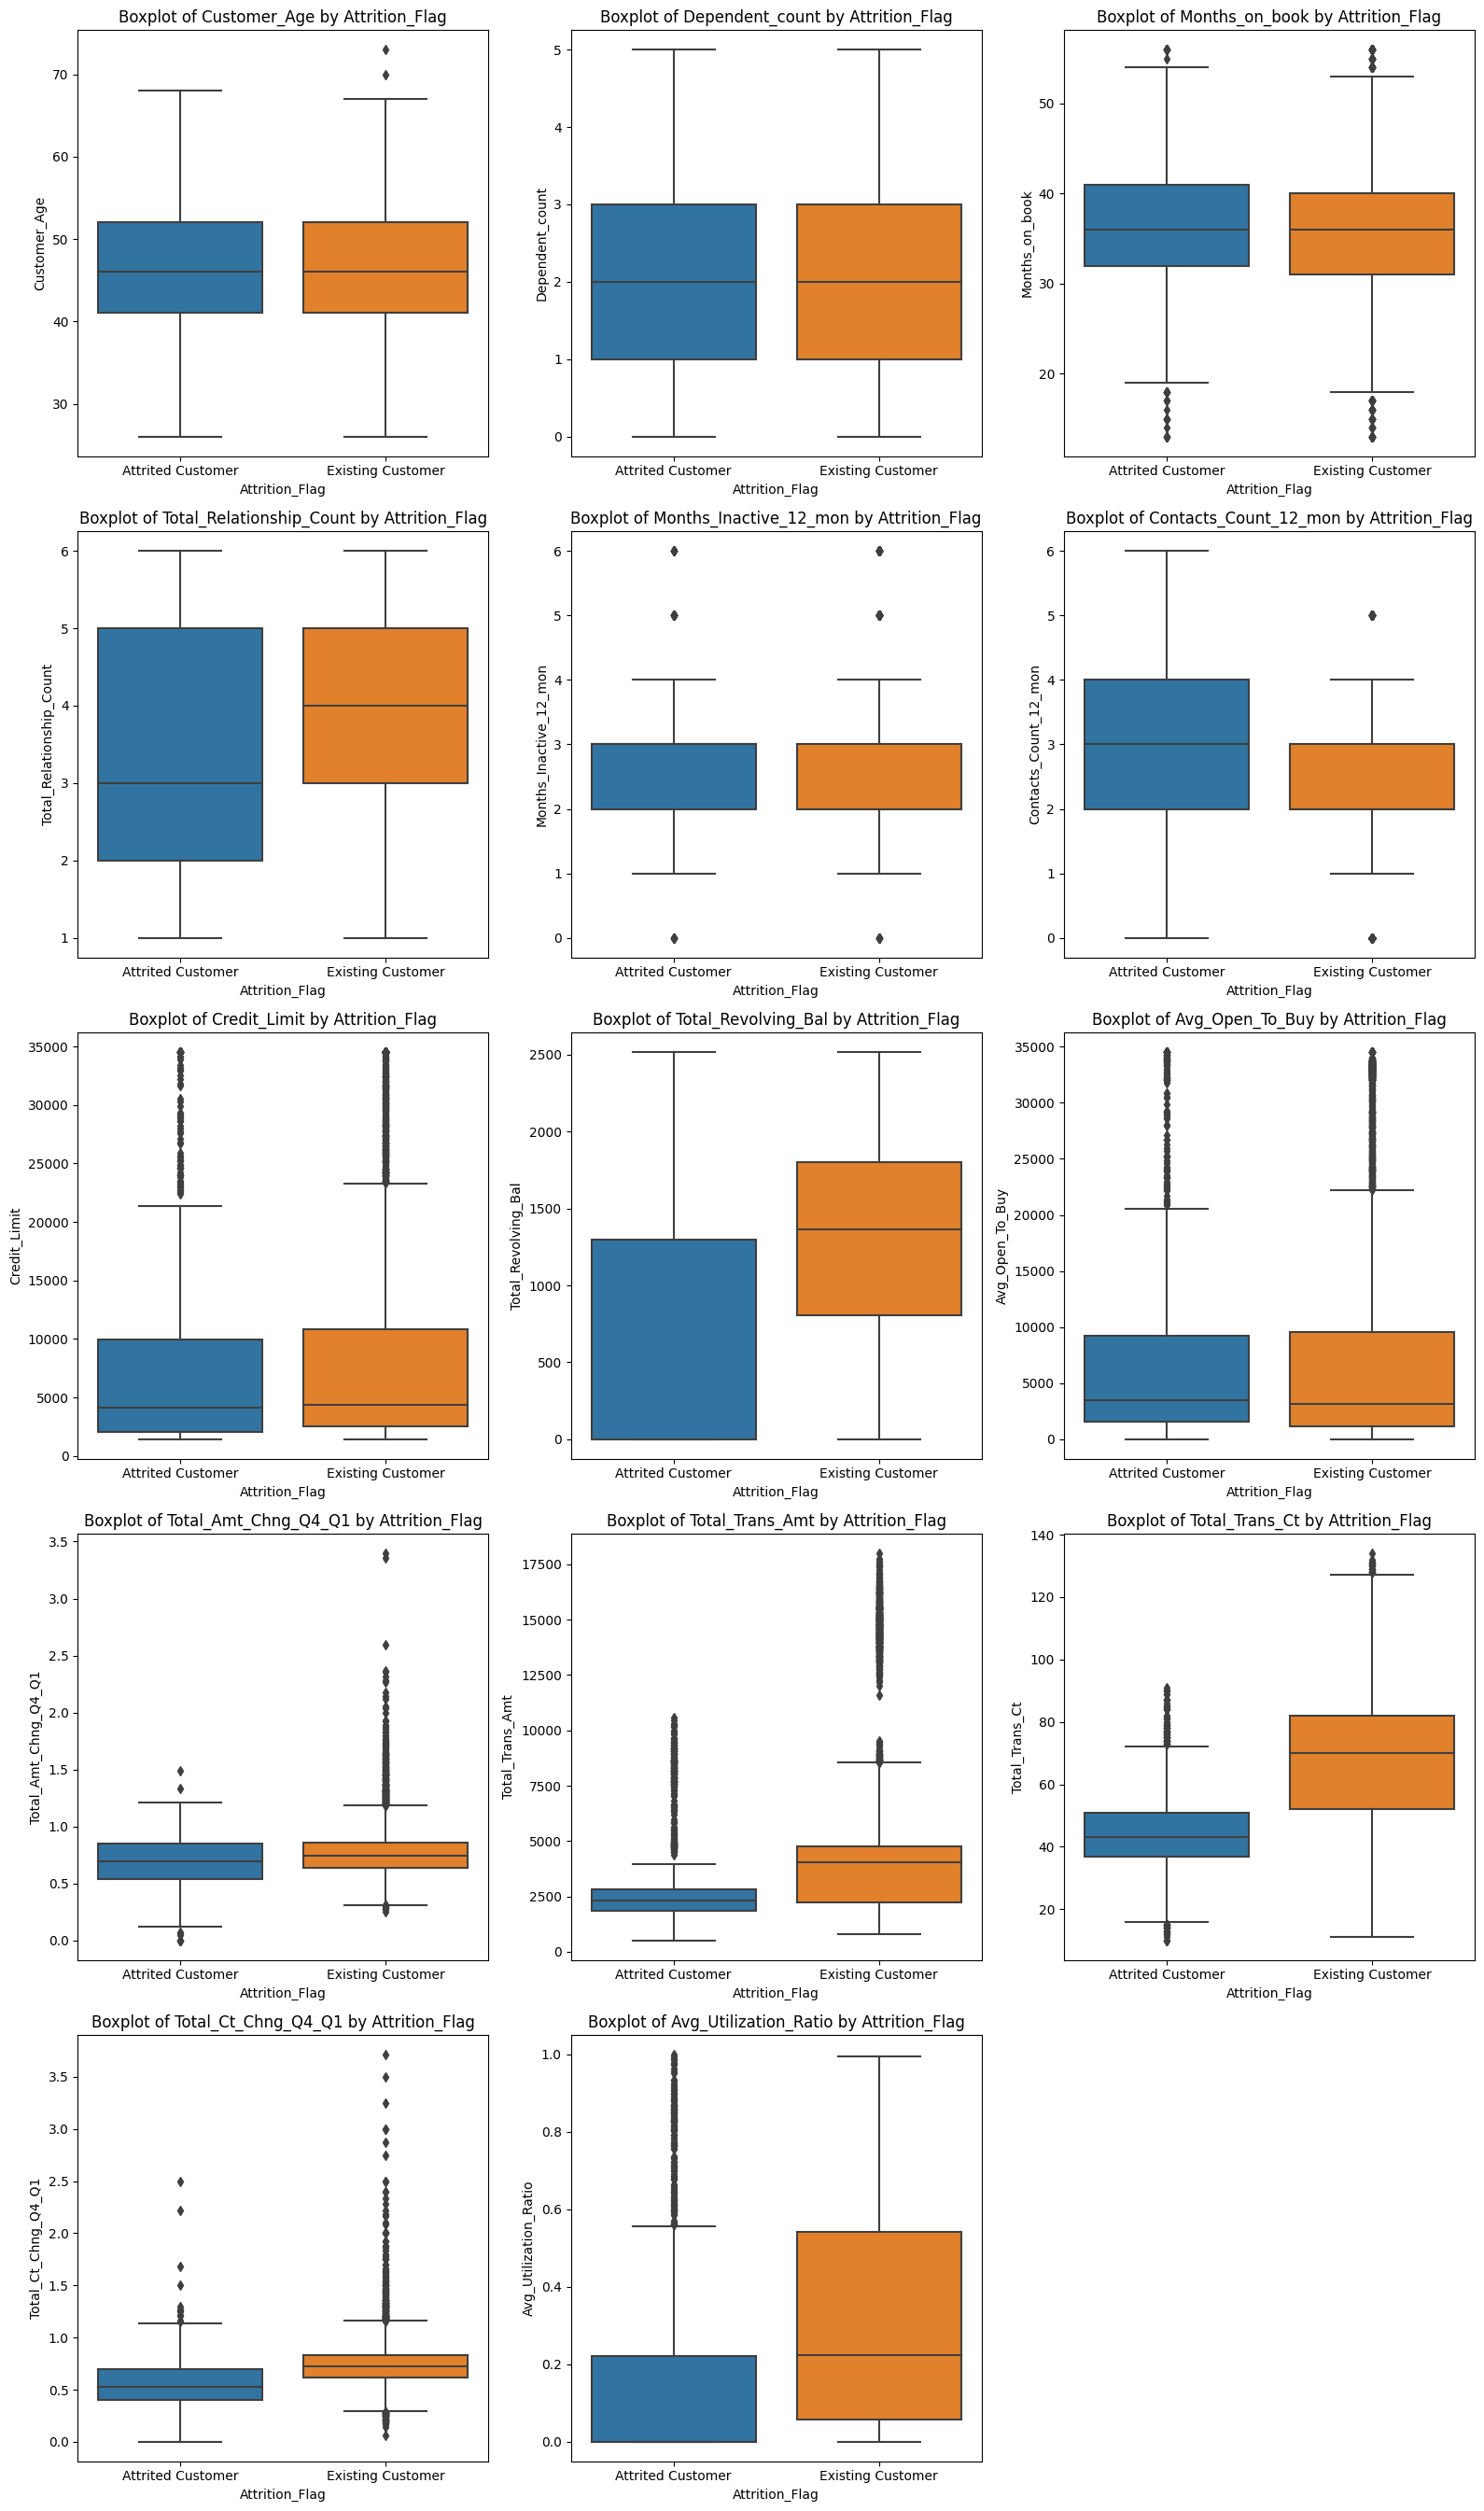

In [10]:
# Box plots

df_numerical = dfNew.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(16, 27))
num_cols = len(df_numerical.columns)
rows = 5
cols = num_cols // rows + (num_cols % rows > 0)

for i, column in enumerate(df_numerical.columns, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(x='Attrition_Flag', y=column, data=dfNew)
    plt.title(f'Boxplot of {column} by Attrition_Flag')
plt.tight_layout()
plt.show()

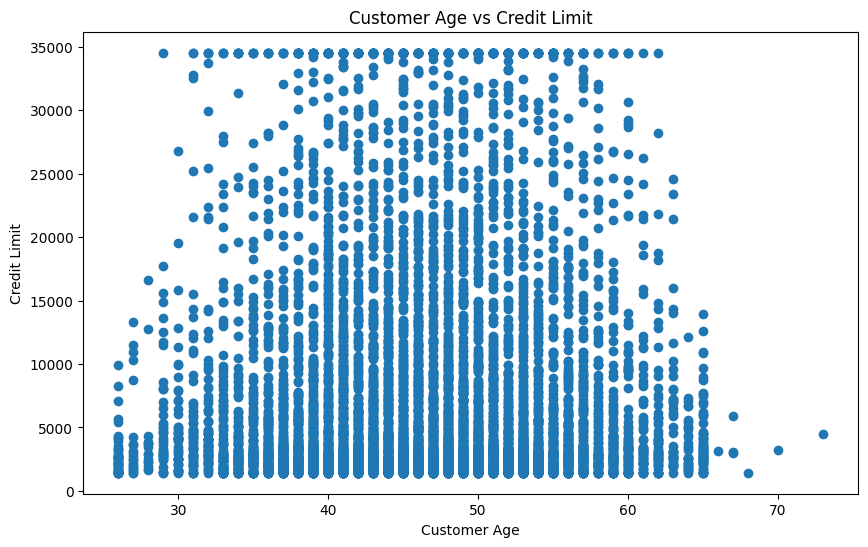

In [11]:
# Scatter plot of Customer Age vs Credit Limit

plt.figure(figsize=(10, 6))
plt.scatter(dfNew['Customer_Age'], dfNew['Credit_Limit'])

plt.xlabel('Customer Age')
plt.ylabel('Credit Limit')
plt.title('Customer Age vs Credit Limit')

plt.show()

# Some Preliminary Insights from EDA

**From the many plots above, we can already pick out some notable points;**

* Married people tend to subscribe to credit card the most, followed by singles. Divorced individuals significantly subscribe less.
* More males are subscribed to credit card than females. However, females tend to have more attrition cases.
* People earning less than 40k a year significantly subscribe to credit card more than people in other income categories. People earning over 120k significantly subscribe less.
* Graduates, high-school students, and unemployed individuals subscribe to credit card the most. Post graduates and people on the doctorate level subscribe the least.
* Credit Limit uniformly increases as age increases up to around age 50, then starts dropping as age grew further.

In [12]:
# Encoding categorical columns

# Defining mappings for ordinal categories
class_mapping = {'Existing Customer': 0, 'Attrited Customer': 1}
income_mapping = {'Less than $40K': 1, '$40K - $60K': 2, '$60K - $80K': 3, '$80K - $120K': 4, '$120K +': 5}
education_mapping = {'Uneducated': 1, 'High School': 2, 'College': 3, 'Graduate': 4, 'Post-Graduate': 5, 'Doctorate': 6}

# Encoding classes and ordinal categories
dfNew['Attrition_Flag'] = dfNew['Attrition_Flag'].map(class_mapping)
dfNew['Income_Category'] = dfNew['Income_Category'].map(income_mapping)
dfNew['Education_Level'] = dfNew['Education_Level'].map(education_mapping)

# Dummy encoding nominal categories
gender_mapping = {'M': 0, 'F': 1}
dfNew['Gender'] = dfNew['Gender'].map(gender_mapping)
dfNew = pd.get_dummies(dfNew, columns=['Card_Category'], prefix='Card_Category', drop_first=False)
dfNew = pd.get_dummies(dfNew, columns=['Marital_Status'], prefix='Marital_Status', drop_first=False)

# Display the modified DataFrame
dfNew.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Income_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,...,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single
0,0,45,0,3,2,3,39,5,1,3,...,42,1.625,0.061,True,False,False,False,False,True,False
1,0,49,1,5,4,1,44,6,1,2,...,33,3.714,0.105,True,False,False,False,False,False,True
2,0,51,0,3,4,4,36,4,1,0,...,20,2.333,0.000,True,False,False,False,False,True,False
3,0,40,0,3,1,3,21,5,1,0,...,28,2.500,0.000,True,False,False,False,False,True,False
4,0,44,0,2,4,2,36,3,1,2,...,24,0.846,0.311,True,False,False,False,False,True,False


In [13]:
# Split dataset into Train and Test sets

'''
    We will use the train set to train the model and evaluate it with
    the test set - data it had not been previously exposed to.
'''

X = dfNew.drop('Attrition_Flag', axis=1) 
y = dfNew['Attrition_Flag']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create dataframes of from splitted datasets
trainSet = pd.DataFrame(X_train).reset_index(drop=True)
trainSet['Attrition_Flag'] = y_train.reset_index(drop=True)

testSet = pd.DataFrame(X_test).reset_index(drop=True)
testSet['Attrition_Flag'] = y_test.reset_index(drop=True)

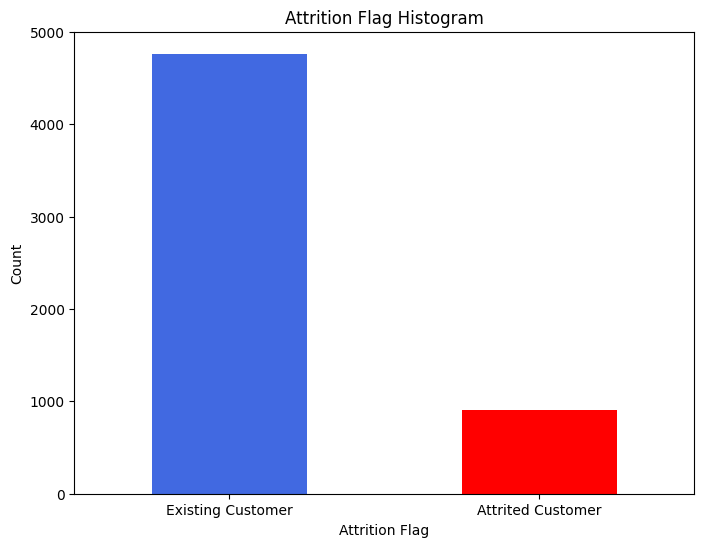

In [14]:
# Checking for class imbalance before training model
attrition_flag_counts = trainSet['Attrition_Flag'].value_counts()

# Plot the histogram
plt.figure(figsize=(8, 6))
attrition_flag_counts.plot(kind='bar', color=['royalblue', 'red'])
plt.title('Attrition Flag Histogram')
plt.xlabel('Attrition Flag')
plt.ylabel('Count')
plt.xticks(list(Counter(y_train).keys()), ['Existing Customer', 'Attrited Customer'], rotation=0)
plt.show()

In [15]:
# Random undersampling of the majority class
undersampler = RandomUnderSampler(sampling_strategy=0.3, random_state=42)
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

# Oversampling the minority class using SMOTE
cat_feats = [1, 3, 4]
smote = SMOTENC(sampling_strategy='minority', categorical_features=cat_feats, random_state=42)
X_train_final, y_train_final = smote.fit_resample(X_train_undersampled, y_train_undersampled)

y_train_final.info()

<class 'pandas.core.series.Series'>
RangeIndex: 6006 entries, 0 to 6005
Series name: Attrition_Flag
Non-Null Count  Dtype   
--------------  -----   
6006 non-null   category
dtypes: category(1)
memory usage: 6.1 KB


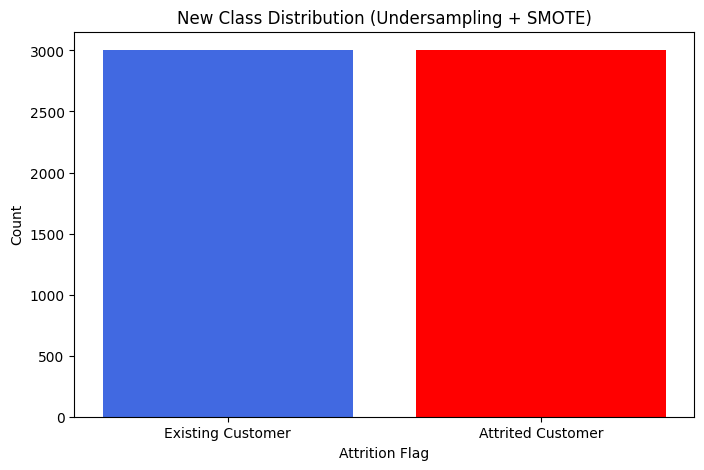

In [16]:
# Checking if class has been balanced

plt.figure(figsize=(8, 5))
plt.bar(Counter(y_train_final).keys(), Counter(y_train_final).values(), color=['royalblue', 'red'])
plt.title('New Class Distribution (Undersampling + SMOTE)')
plt.xlabel('Attrition Flag')
plt.ylabel('Count')
plt.xticks(list(Counter(y_train_final).keys()), ['Existing Customer', 'Attrited Customer'])
plt.show()

**Above, we found the ratio of existing customers to churned was approximately 4:1. An imbalanced class could introduce bias and affect the performance of the Random Forest model. We performed random undersampling to reduce the majority classes a bit then oversampled the minority class using SMOTE to balance the two classes.**

In [17]:
# Train RandomForest Classifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train_final, y_train_final)
y_pred = rf_classifier.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report (includes precision, recall, f1-score)
classification_rep = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(classification_rep)

Confusion Matrix:
[[1158   47]
 [  25  187]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1205
           1       0.80      0.88      0.84       212

    accuracy                           0.95      1417
   macro avg       0.89      0.92      0.90      1417
weighted avg       0.95      0.95      0.95      1417



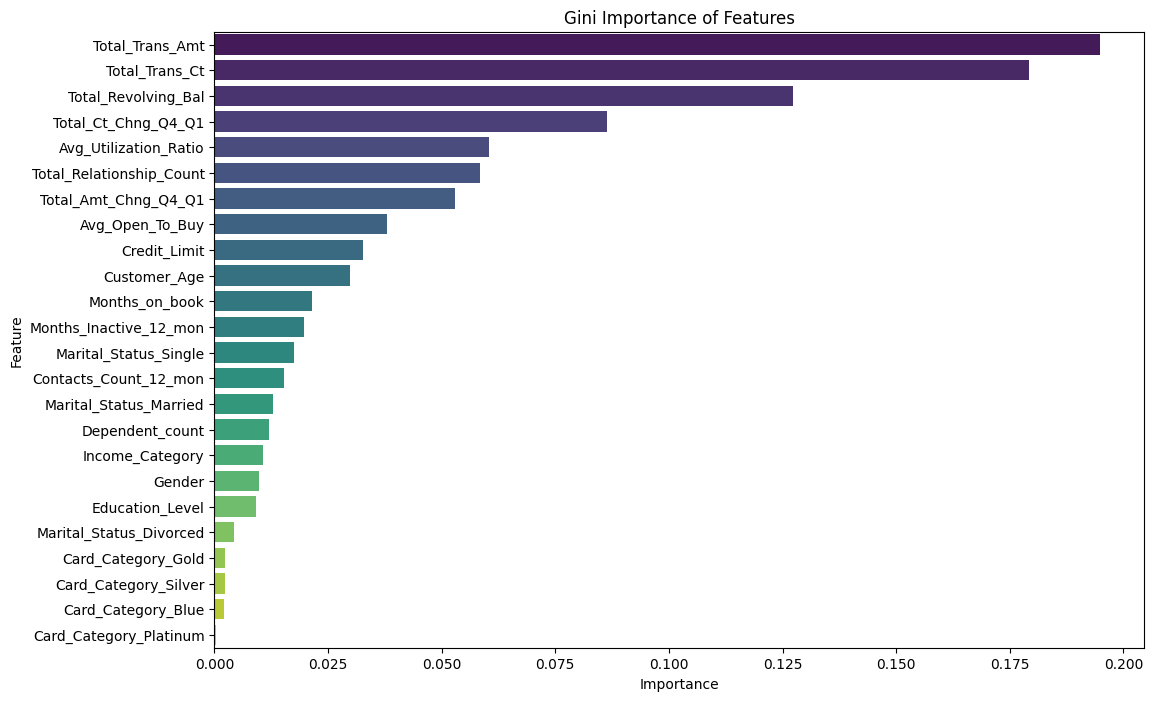

In [18]:
# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame to store feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Gini Importance of Features')
plt.show()

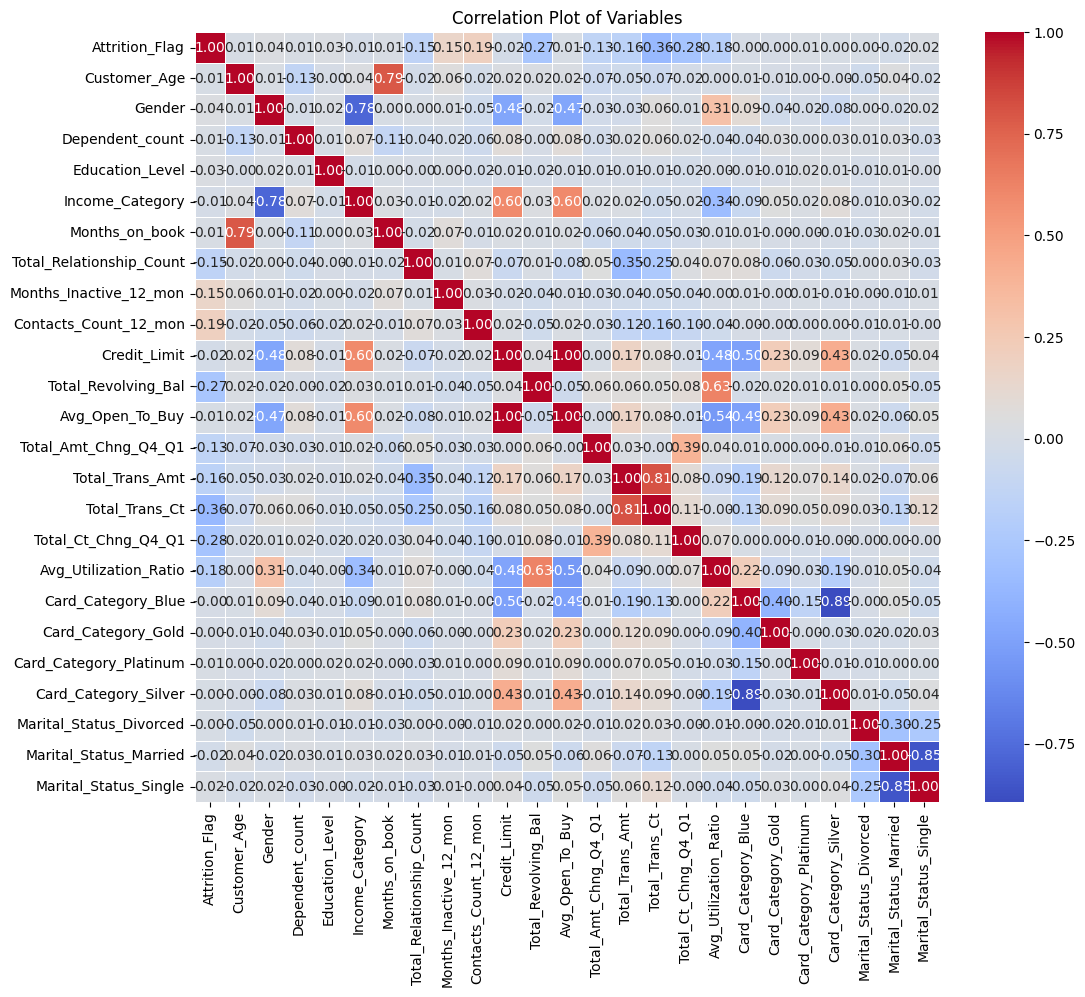

In [19]:
# Before performing linear regression modelling, we investigate multicollinearity

'''
    Although, if present, multicollinearity might not exactly affect the 
    performance of the logistic regression model. We, however, want to be 
    able to explain the effects that each feature has on attrition independently, hence 
    the need to avoid multicollinearity by removing (one of) highly correlated features.
'''

# Firstly, we plot the correlation matrix

correlation_matrix = dfNew.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Plot of Variables')
plt.show()

In [20]:
# Remove one of highly correlated variables to avoid multicollinearity

X_train = X_train.drop(['Months_on_book', 'Avg_Open_To_Buy', 'Marital_Status_Single', 'Total_Trans_Ct', 'Card_Category_Blue'], axis=1)
X_train.head()

,Customer_Age,Gender,Dependent_count,Education_Level,Income_Category,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver,Marital_Status_Divorced,Marital_Status_Married
3409,55,1,2,4,1,4,3,3,1724.0,0,0.936,4434,0.811,0.000,False,False,False,False,False
4038,50,0,2,4,4,3,3,3,12906.0,321,0.760,2078,0.550,0.025,False,False,False,False,True
6075,44,0,4,4,5,2,2,1,34516.0,1635,0.768,7219,0.564,0.047,False,False,True,False,False
530,37,0,4,4,3,5,3,2,2578.0,2517,0.896,1830,0.524,0.976,False,False,False,False,True
5482,50,1,2,4,1,2,1,2,1438.3,491,0.730,5102,0.694,0.341,False,False,False,False,True


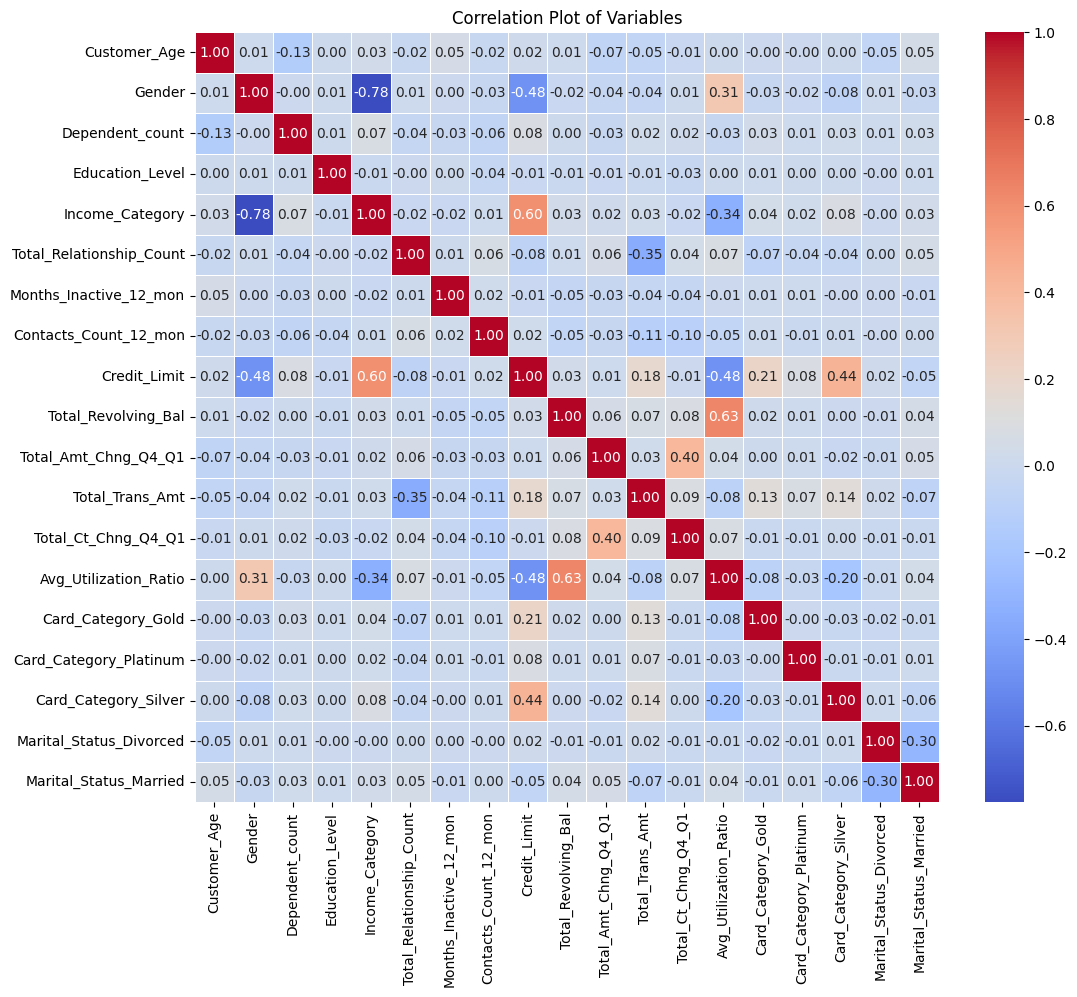

In [21]:
# Viewing correlation matrix again

correlation_matrix = X_train.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Plot of Variables')
plt.show()

In [22]:
#Fitting Linear Regression Model

# Convert boolean columns to integers
X_train['Card_Category_Gold'] = X_train['Card_Category_Gold'].astype(int)
X_train['Card_Category_Platinum'] = X_train['Card_Category_Platinum'].astype(int)
X_train['Card_Category_Silver'] = X_train['Card_Category_Silver'].astype(int)
X_train['Marital_Status_Divorced'] = X_train['Marital_Status_Divorced'].astype(int)
X_train['Marital_Status_Married'] = X_train['Marital_Status_Married'].astype(int)

# Add a constant term to the features for the intercept
X_train_with_intercept = sm.add_constant(X_train)

# Create a logistic regression model using Statsmodels
logit_model = sm.GLM(y_train, X_train_with_intercept, family=sm.families.Binomial())

# Fit the model
result = logit_model.fit()

# Print the summary of the logistic regression
print(result.summary())

# Odds Ratio
odds_ratios = np.exp(result.params)
print("Odds Ratios:")
print(odds_ratios)

                 Generalized Linear Model Regression Results                  
Dep. Variable:         Attrition_Flag   No. Observations:                 5664
Model:                            GLM   Df Residuals:                     5644
Model Family:                Binomial   Df Model:                           19
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1765.0
Date:                Fri, 01 Mar 2024   Deviance:                       3530.0
Time:                        22:34:27   Pearson chi2:                 8.99e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2235
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [23]:
# Evaluating LR Model

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store cross-validation scores
cv_scores = []

for train_index, test_index in kf.split(X_train_with_intercept):
    X_train_cv, X_test_cv = X_train_with_intercept.iloc[train_index], X_train_with_intercept.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

    # Create and fit the logistic regression model
    logit_model_cv = sm.GLM(y_train_cv, X_train_cv, family=sm.families.Binomial())
    result_cv = logit_model_cv.fit()

    # Make predictions on the test set
    y_pred_cv = result_cv.predict(X_test_cv)
    y_pred_class_cv = (y_pred_cv > 0.5).astype(int)

    # Evaluate the model and store the accuracy
    accuracy_cv = accuracy_score(y_test_cv, y_pred_class_cv)
    cv_scores.append(accuracy_cv)

# Calculate and print the average cross-validation accuracy
average_cv_accuracy = sum(cv_scores) / len(cv_scores)
print("Average Cross-Validation Accuracy:", average_cv_accuracy)

Average Cross-Validation Accuracy: 0.8868278656058683


# Results & Discussions

**The RF model demonstrates an impressive accuracy of 0.95**, with a commendable **Recall value of 0.88** for the attrition class, signifying its ability to effectively predict customer churn instances.

**In addition, the LR model achieves an accuracy score of approximately 0.89**.

Upon examining the feature importance in the RF model, it's evident that certain attributes such as **Card Categories, Education Level, and Marital Statuses (excluding Married)** rank lower in significance.

Similarly, the LR analysis reveals insignificance **(P > 0.05)** for all **Card Categories, Education Level, and Marital Statuses**, aligning impressively with the RF findings. However, there is a discrepancy regarding **Total Amt Chng (Q4-Q1)**, which is deemed highly significant by RF but not by LR. 

Further exploration using Odds Ratios derived from LR exposes notable insights. For instance, **compared to men (the reference class), women exhibit higher odds of credit card attrition, despite a higher male population**. This observation is consistent with the attrition percentages pie charts plotted earlier in the analysis.

Additionally, **as Income Category rises (relative to the lowest category), there is a 22% (1.221243 - 1) increase in the odds of attrition occurrence**. Similarly, **an increase in Inactive Months correlates with increase in attrition odds**.

Conversely, **a rise in Transaction Amount corresponds to slightly diminished odds of attrition (0.999808 - 1)**. This correlation aligns with the trend observed in the box plot plotted earlier in the analysis, where existing customers typically exhibit higher transaction amounts than those who churn.

This comprehensive analysis underscores the potential for businesses to proactively predict credit card churn and gain valuable insights into contributing factors. Businesses can go on to establish real-time monitoring dashboards for significant customer attributes and implement targeted marketing strategies based on observed changes. Leveraging customer classification using the predictive power can further enhance personalised marketing efforts and customer retention initiatives.